# Imports

In [1]:
# import library
%run lib.ipynb
# reset_random_state(17)

# Plot poisson
($\lambda=1,4,10$)

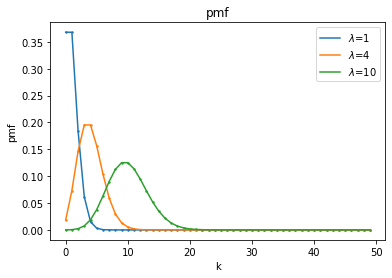

In [2]:
from collections.abc import Iterable

def plot_poisson(mu, M):

    plt.title(f'pmf')
    plt.xlabel('k')
    plt.ylabel('pmf')
    
    k = np.array(range(M))
    
    if isinstance(mu, Iterable):
        
        for mu_i in mu:

            # pmf
            pmf_i = poisson.pmf(k=range(M), mu=mu_i)
            
            # plot
            x = k
            y = pmf_i
            _ = plt.scatter(x, y, zorder=1, s=2)
            _ = plt.plot(x, y, zorder=2, label=f'$\lambda$={mu_i}')
    else: # single
        
        # pmf
        pmf = poisson.pmf(k=range(M), mu=mu)
        
        # plot
        x = k
        y = pmf
        _ = plt.scatter(x, y, zorder=1, s=2)
        _ = plt.plot(x, y, zorder=2, label=f'$\lambda$={mu}')
    
    plt.legend()

# plot_poisson(mu=1, M=20)
plot_poisson(mu=[1, 4, 10], M=50)

## Plot sample data

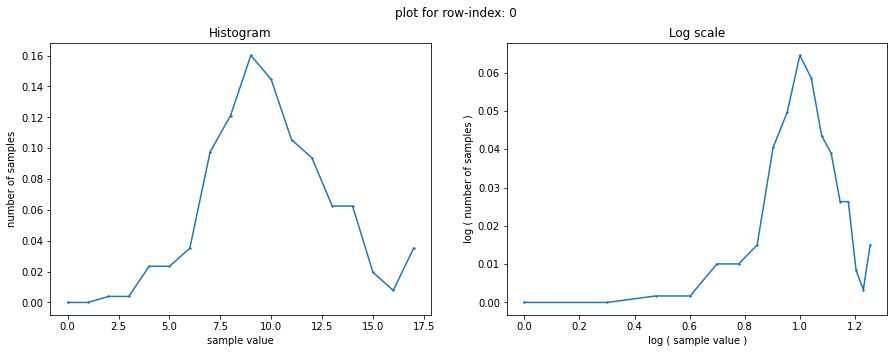

In [3]:
# plot helper function
def plot_histogram_and_logscale(H, lambdas):
    """
    plot data:
        - histogram
        - log scale
    """

    # two plots side by side
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    # select random row index
    ROW_INDEX_TO_PLOT = random.randint(0, H.shape[0] - 1)
    lam = lambdas[ROW_INDEX_TO_PLOT]
    fig.suptitle(f'plot for row-index: {ROW_INDEX_TO_PLOT}')
    
    # plot histogram
    y = H[ROW_INDEX_TO_PLOT,:]
    x = np.array(range(len(y)))
    
    ax1.set_title(f'Histogram')
    ax1.set_xlabel('sample value')
    ax1.set_ylabel('number of samples')
    ax1.scatter(x, y, zorder=1, s=2)
    ax1.plot(x, y, zorder=2)
    
    # plot log scale
    # (shift H values by one so as not to take log of zero)
    x = np.log10(x + 1)
    y = np.log10(y + 1)
    
    ax2.set_title('Log scale')
    ax2.set_xlabel('log ( sample value )')
    ax2.set_ylabel('log ( number of samples )')
    ax2.scatter(x, y, zorder=1, s=2)
    ax2.plot(x, y, zorder=2)

# generate data
samples, H, lambdas = generate_data(N=1, M=256, nextConfig=10.0, sample=sample_poisson, density=True)

# plot single input row
plot_histogram_and_logscale(H, lambdas)

# Experiments
Learn Poisson in three different settings:

Use exact values.  
Use Log.  
Use P values, defined from the poisson thingy.  
P(k) = Log(MEASURED(k) * k!)

## Experiment 1 - log vs. exact training

In [4]:
def experiment_1(N = 10000):
    
    trials = []
    
    d = {
        'M': [], 
        'm': [],
        'log-scale': [],
        'sqrt-mse': [],
        'train-time (sec.)': []
    }

    for M in [64, 128, 256, 512, 1024, 2048, 4096, 8192]:
        
        print()
        print(f'generating dataset (M={M}) ... ', end='')
        samples, H, lambdas = generate_data(N=N, M=M, nextConfig=next_lambda, sample=sample_poisson)
        X_train, X_test, y_train, y_test = train_test_split(H, lambdas, test_size=0.25)
        print(f'train input.shape: {X_train.shape}')

        m = X_train.shape[1]
        
        for apply_log_scale in [True, False]:

            if apply_log_scale:
                X_train = log_scale(X_train)
                X_test = log_scale(X_test)
                print(f'training (log-scale) ... ', end='')
            else:
                print(f'training (exact-values) ... ', end='')

            start_time = time.time()
            dnn_model, history, y_pred, sqrt_mse = dnn_trial(X_train, y_train, X_test, y_test) ### lilo
            train_time = round(time.time() - start_time)
            print(f'sqrt-mse: {sqrt_mse:.4f}, train-time: {round(train_time)} sec.')

            trials.append({
                'model': dnn_model,
                'history': history,
                'y-test': y_test,
                'y-pred': y_pred,
                'sqrt-mse': sqrt_mse,
                'train-time': train_time
            })

            
            d['M'].append(M)
            d['m'].append(m)
            d['log-scale'].append(apply_log_scale)
            d['sqrt-mse'].append(round(sqrt_mse, 4))
            d['train-time (sec.)'].append(f'{train_time}')
    
    df = pd.DataFrame(data=d)
    return trials, df

exp_1_trials, exp_1_df = experiment_1()


generating dataset (M=64) ... train input.shape: (7500, 24)
training (log-scale) ... sqrt-mse: 0.2969, train-time: 34 sec.
training (exact-values) ... sqrt-mse: 0.2998, train-time: 19 sec.

generating dataset (M=128) ... train input.shape: (7500, 26)
training (log-scale) ... sqrt-mse: 0.2079, train-time: 33 sec.
training (exact-values) ... sqrt-mse: 0.2164, train-time: 36 sec.

generating dataset (M=256) ... train input.shape: (7500, 26)
training (log-scale) ... sqrt-mse: 0.1634, train-time: 35 sec.
training (exact-values) ... sqrt-mse: 0.2032, train-time: 19 sec.

generating dataset (M=512) ... train input.shape: (7500, 26)
training (log-scale) ... sqrt-mse: 0.1215, train-time: 50 sec.
training (exact-values) ... sqrt-mse: 0.1179, train-time: 49 sec.

generating dataset (M=1024) ... train input.shape: (7500, 28)
training (log-scale) ... 

KeyboardInterrupt: 

In [ ]:
# plot sqrt-mse for log-scale vs. exact
def plot_log_scale_vs_exact(df):
    M_values = df.loc[df['log-scale'] == True][['M']].values
    sqrt_mse_log_scale = df.loc[df['log-scale'] == True][['sqrt-mse']].values
    sqrt_mse_exact = df.loc[df['log-scale'] == False][['sqrt-mse']].values
    _ = plt.plot(M_values, sqrt_mse_log_scale, label='log-scale')
    _ = plt.plot(M_values, sqrt_mse_exact, label='exact')
    plt.title('sqrt-mse for log-scale vs. exact values')
    plt.xlabel('M')
    plt.ylabel('sqrt-mse')
    _ = plt.legend()

plot_log_scale_vs_exact(exp_1_df)
exp_1_df